In [32]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import multiclass
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D, Activation, SpatialDropout1D, LSTM, SimpleRNN, Lambda
from keras.optimizers import Adam, SGD, RMSprop
from keras import losses, optimizers
from keras import preprocessing
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

import tensorflow as tf

Izvršićemo klasifikaciju podataka neurnoskim mrežama za različit broj kategorija (2, 10, 36). Učitaćemo podatke i odraditi vektorizaciju, a zatim podeliti na podatke na trening, test i validacione skupove. Isprobavali smo različite vrednosti za parametre modela (units, epochs, batch_size, learning_rate) kao i broj slojeva i za ove vrednosti smo dobili najbolje moguće modele za naše podatke.

Funkcija <i>GetData</i> će nam služiti za učitavanje podataka u zavisnosti od broja kategorija.

In [2]:
def GetData(num_of_categories, categories):
    news = pd.read_csv('data/vesti.csv')
    if num_of_categories == 36:
        X = news['text']
        y = news['category']
    else:
        news = news[news.category.isin(categories)]
        X = news['text']
        y = news['category']
        
    return (X, y)

Funkcija <i>TransformData</i> izršava vektorizaciju nad skupom X i prevodi kategoričke vrednosti skupa y u indikatorske promenljive.

In [3]:
def TransformData(X, y):
    vectorizer = feature_extraction.text.CountVectorizer(min_df=0)
    vectorizer.fit(X.values.astype('U'))

    X_transformed = vectorizer.transform(X.values.astype('U'))

    y_transformed = pd.get_dummies(y).values
    
    return (X_transformed, y_transformed)

Funkcija <i>TrainTestValidationSplit</i> deli podatke na trening, validacioni (validation size: 0.2) i test (test size: 0.2) skup sa stratifikacijom po y skupu.

In [4]:
def TrainTestValidationSplit(X, y):
    X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 4)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size = 0.2, stratify = y_train_validation, random_state = 4)
    
    return (X_train, X_validation, X_test, y_train, y_validation, y_test)

Funkcija <i>EvaluateModel</i> će služiti za evaluaciju podataka na test skupu i vizualizaciju dobijenih vrednosti funkcije greške i tačnosti.

In [5]:
def EvaluateModel(model, X_test, y_test, history):
    score = model.evaluate(X_test, y_test)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])
    
    epochs = history.epoch
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12,8))
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs, loss, c='red', label = 'training')
    plt.plot(epochs, validation_loss, c='orange', label='validation')
    plt.legend(loc = 'best')
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs, accuracy, c='red', label = 'training')
    plt.plot(epochs, validation_accuracy, c = 'orange', label = 'validation')
    plt.legend(loc = 'best')
    plt.show()

### Klasifikacija za 2 kategorije

Učitavamo podatke za dve kategorije koje imaju najveći broj članaka u skupu.

In [155]:
categories2 = ['WOMEN', 'FOOD & DRINK']
X2, y2 = GetData(2, categories2)
print(X2.shape)
print(y2.shape)

(9570,)
(9570,)


Transformišemo podatke i delimo ih na skupove za trening, test i validaciju.

In [156]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X2, y2, test_size = 0.2, stratify = y2, random_state = 4)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size = 0.3, stratify = y_train_validation, random_state = 4)

In [157]:
vectorizer1 = feature_extraction.text.TfidfVectorizer(min_df=0)
vectorizer1.fit(X_train_validation.values.astype('U'))
X2_test = vectorizer1.transform(X_test.values.astype('U'))

vectorizer2 = feature_extraction.text.TfidfVectorizer(min_df=0)
vectorizer2.fit(X_train.values.astype('U'))
X2_train = vectorizer2.transform(X_train.values.astype('U'))
X2_validation = vectorizer2.transform(X_validation.values.astype('U'))

y2_test = pd.get_dummies(y_test).values
y2_train = pd.get_dummies(y_train).values
y2_validation = pd.get_dummies(y_validation).values

In [158]:
pca1 = decomposition.TruncatedSVD(n_components=1000, random_state=4)
pca1.fit(X2_test)
print(sum(pca1.explained_variance_ratio_))
X2_test = pca1.transform(X2_test)
print(X2_test.shape)

0.827032917134876
(1914, 1000)


In [159]:
pca2 = decomposition.TruncatedSVD(n_components=1000, random_state=4)
pca2.fit(X2_train)
print(sum(pca2.explained_variance_ratio_))
X2_train = pca2.transform(X2_train)
print(X2_train.shape)

0.6146582151328952
(5359, 1000)


In [160]:
pca3 = decomposition.TruncatedSVD(n_components=1000, random_state=4)
pca3.fit(X2_validation)
print(sum(pca3.explained_variance_ratio_))
X2_validation = pca3.transform(X2_validation)
print(X2_validation.shape)

0.7959345724902287
(2297, 1000)


In [161]:
print(X2_test.shape)
print(y2_test.shape)
print(X2_train.shape)
print(y2_train.shape)
print(X2_validation.shape)
print(y2_validation.shape)

(1914, 1000)
(1914, 2)
(5359, 1000)
(5359, 2)
(2297, 1000)
(2297, 2)


Kreiramo model i zatim prikazujemo rezultate.

In [196]:
callback2 = EarlyStopping(monitor="val_loss", patience=3)
model2 = Sequential()
model2.add(Dense(units = 100, input_dim = X2_train.shape[1], activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units = 50, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(2, activation = 'softmax'))

model2.compile(optimizer = Adam(learning_rate = 0.01), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model2.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 100)               100100    
_________________________________________________________________
dropout_84 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_85 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 2)                 102       
Total params: 105,252
Trainable params: 105,252
Non-trainable params: 0
_________________________________________________________________


In [197]:
history2 = model2.fit(X2_train, y2_train, epochs=30, batch_size=128, callbacks=[callback2], validation_data=(X2_validation, y2_validation))

Epoch 1/30
42/42 [==============================] - 0s 6ms/step - loss: 0.2997 - accuracy: 0.8595 - val_loss: 3.5179 - val_accuracy: 0.4567
Epoch 2/30
42/42 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.9789 - val_loss: 4.3802 - val_accuracy: 0.5033
Epoch 3/30
42/42 [==============================] - 0s 4ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 5.1904 - val_accuracy: 0.4754
Epoch 4/30
42/42 [==============================] - 0s 4ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 5.8428 - val_accuracy: 0.4950


60/60 [==============================] - 0s 818us/step - loss: 1.3895 - accuracy: 0.7706
Test loss:  1.3894846439361572
Test accuracy:  0.7706373929977417


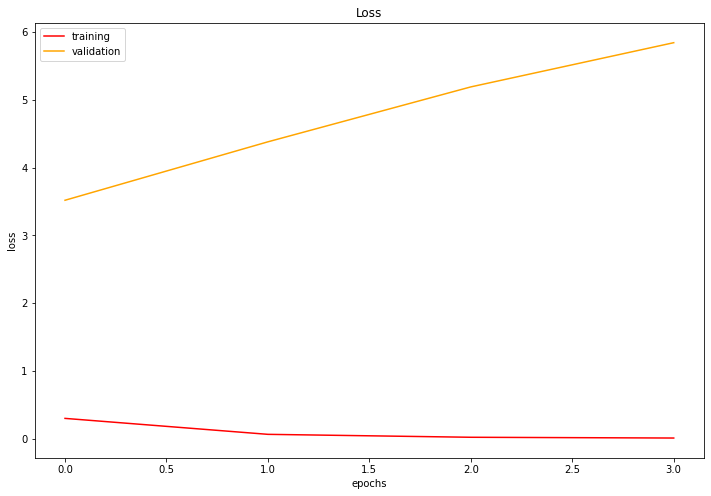

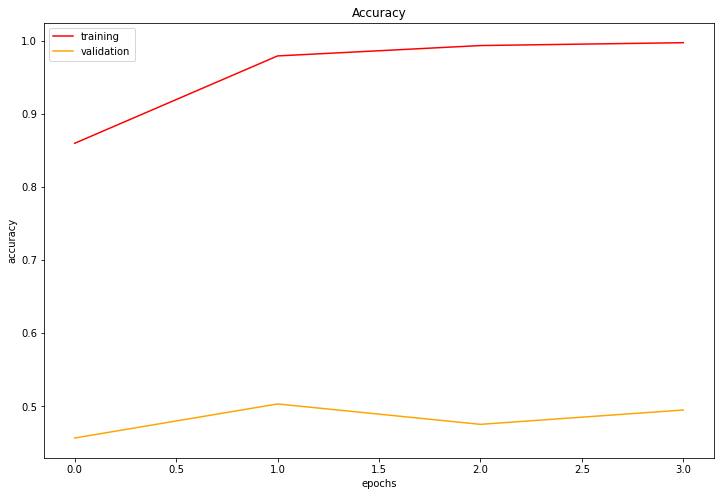

In [198]:
EvaluateModel(model2, X2_test, y2_test, history2)

In [199]:
p = model2.predict_classes(X2_test, verbose=0)
print(metrics.classification_report(np.argmax(y2_test, axis=1), p))
print(metrics.confusion_matrix(np.argmax(y2_test, axis=1), p))
print(metrics.f1_score(np.argmax(y2_test, axis=1), p))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1242
           1       0.68      0.66      0.67       672

    accuracy                           0.77      1914
   macro avg       0.75      0.75      0.75      1914
weighted avg       0.77      0.77      0.77      1914

[[1032  210]
 [ 229  443]]
0.6686792452830189


Klasifikaciju za 10 i 36 kategorija nismo izmenile zato sto izvrsavanje nad tolikom kolicinom podataka ce dugo trajati a nismo pri vremenu, tako da smo ovo ostavile jer je ovo bilo i prikazano na odbrani rada.

### Klasifikacija za 10 kategorija

Ponovićemo postupak kao za klasifikaciju za 2 kategorije samo uz drugačiji model. Koristili smo 10 kategorija koje smo koristili i u svsci knn_and_bayes10.ipynb.

In [16]:
categories10 = ['DIVORCE', 'WEDDINGS', 'STYLE AND BEAUTY', 'QUEER VOICES', 'POLITICS', 'HOME & LIVING', 'TRAVEL', 'WORLD NEWS', 'SPORTS', 'ENTERTAINMENT']
X10, y10 = GetData(10, categories10)

In [17]:
print(X10.shape)
print(y10.shape)

(100100,)
(100100,)


In [18]:
X10_transformed, y10_transformed = TransformData(X10, y10)

In [19]:
print(X10_transformed.shape)
print(y10_transformed.shape)

(100100, 70788)
(100100, 10)


In [20]:
X10_train, X10_validation, X10_test, y10_train, y10_validation, y10_test = TrainTestValidationSplit(X10_transformed, y10_transformed)

In [21]:
print(X10_train.shape)
print(X10_test.shape)

(64064, 70788)
(20020, 70788)


In [22]:
print(y10_train.shape)
print(y10_test.shape)

(64064, 10)
(20020, 10)


In [23]:
print(X10_validation.shape)
print(X10_validation.shape)

(16016, 70788)
(16016, 70788)


In [24]:
callback10 = EarlyStopping(monitor="val_loss", patience=2)
model10 = Sequential()
model10.add(Dense(units = 200, input_dim = X10_train.shape[1], activation = 'relu'))
model10.add(Dropout(0.5))
model10.add(Dense(units = 120, activation = 'relu'))
model10.add(Dropout(0.5))
model10.add(Dense(units = 80, activation = 'relu'))
model10.add(Dropout(0.5))
model10.add(Dense(units = 30, activation = 'relu'))
model10.add(Dropout(0.5))
model10.add(Dense(10, activation = 'softmax'))

model10.compile(optimizer = Adam(learning_rate = 0.0001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model10.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               14157800  
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               24120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                9680      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)               

In [25]:
history10 = model10.fit(X10_train, y10_train, epochs=8, batch_size=128, validation_data=(X10_validation, y10_validation), callbacks=[callback10])

Epoch 1/8
501/501 [==============================] - 42s 84ms/step - loss: 1.9395 - accuracy: 0.3282 - val_loss: 1.5425 - val_accuracy: 0.5406
Epoch 2/8
501/501 [==============================] - 43s 85ms/step - loss: 1.4257 - accuracy: 0.5216 - val_loss: 1.0652 - val_accuracy: 0.6375
Epoch 3/8
501/501 [==============================] - 47s 95ms/step - loss: 1.1104 - accuracy: 0.6181 - val_loss: 0.8740 - val_accuracy: 0.7203
Epoch 4/8
501/501 [==============================] - 57s 115ms/step - loss: 0.9273 - accuracy: 0.6837 - val_loss: 0.7906 - val_accuracy: 0.7547
Epoch 5/8
501/501 [==============================] - 51s 101ms/step - loss: 0.7928 - accuracy: 0.7315 - val_loss: 0.7347 - val_accuracy: 0.7780
Epoch 6/8
501/501 [==============================] - 51s 103ms/step - loss: 0.6842 - accuracy: 0.7662 - val_loss: 0.6873 - val_accuracy: 0.7916
Epoch 7/8
501/501 [==============================] - 48s 96ms/step - loss: 0.5964 - accuracy: 0.7924 - val_loss: 0.6674 - val_accuracy: 0.7

626/626 [==============================] - 1s 1ms/step - loss: 0.6589 - accuracy: 0.7988
Test loss:  0.6588755249977112
Test accuracy:  0.7988011837005615


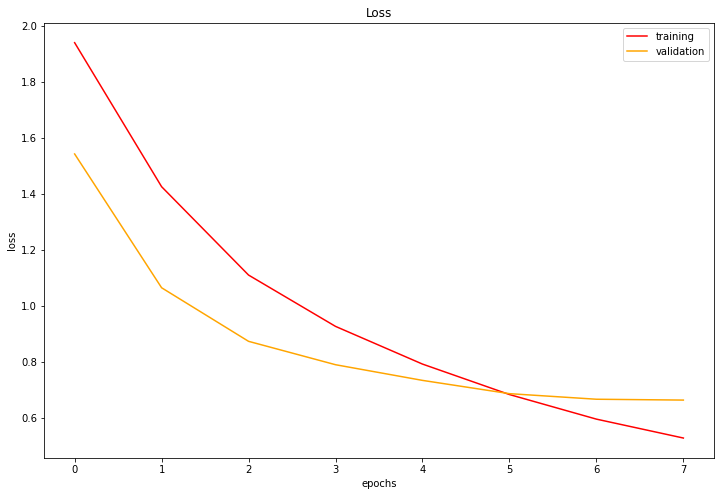

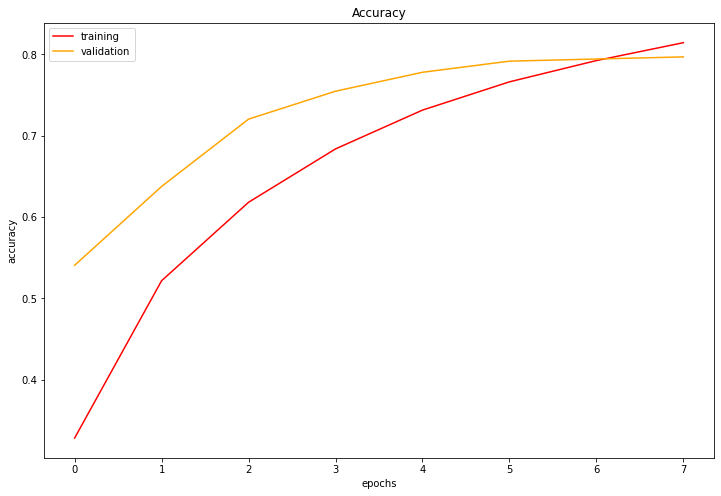

In [26]:
EvaluateModel(model10, X10_test, y10_test, history10)

In [47]:
p10 = model10.predict_classes(X10_test, verbose=0)
print(metrics.classification_report(np.argmax(y10_test, axis=1), p10))
print(metrics.confusion_matrix(np.argmax(y10_test, axis=1), p10))

              precision    recall  f1-score   support

           0       0.81      0.04      0.08       682
           1       0.88      0.90      0.89      3204
           2       0.18      0.00      0.01       813
           3       0.91      0.93      0.92      6514
           4       0.34      0.84      0.49      1259
           5       0.75      0.78      0.77       976
           6       0.89      0.93      0.91      2207
           7       0.91      0.91      0.91      1967
           8       0.50      0.01      0.01       717
           9       0.81      0.80      0.81      1681

    accuracy                           0.80     20020
   macro avg       0.70      0.61      0.58     20020
weighted avg       0.80      0.80      0.77     20020

[[  30   28    8   22  535   26   17    9    0    7]
 [   0 2878    1  131   75   35   39   26    1   18]
 [   0   17    4    9  656   24   62   35    1    5]
 [   0   84    1 6065   37   73    8   22    1  223]
 [   0   77    0   48 1058   

### Klasifikacija za 36 kategorija

In [27]:
X, y = GetData(36, [])
print(X.shape)
print(y.shape)

(198627,)
(198627,)


In [28]:
X_transformed, y_transformed = TransformData(X, y)

In [29]:
print(X_transformed.shape)
print(y_transformed.shape)

(198627, 110570)
(198627, 36)


In [30]:
X_train, X_validation, X_test, y_train, y_validation, y_test = TrainTestValidationSplit(X_transformed, y_transformed)

In [31]:
print(X_train.shape)
print(X_test.shape)

(127120, 110570)
(39726, 110570)


In [32]:
print(y_train.shape)
print(y_test.shape)

(127120, 36)
(39726, 36)


In [33]:
print(X_validation.shape)
print(X_validation.shape)

(31781, 110570)
(31781, 110570)


In [34]:
callback = EarlyStopping(monitor="val_loss", patience=2)
model = Sequential()
model.add(Dense(units = 200, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 150, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 60, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation = 'softmax'))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 200)               22114200  
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 150)               30150     
_________________________________________________________________
dropout_8 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 60)               

In [35]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_validation, y_validation), callbacks=[callback])

Epoch 1/10
994/994 [==============================] - 174s 175ms/step - loss: 3.0705 - accuracy: 0.1874 - val_loss: 2.4975 - val_accuracy: 0.3579
Epoch 2/10
994/994 [==============================] - 195s 196ms/step - loss: 2.4335 - accuracy: 0.3687 - val_loss: 2.0656 - val_accuracy: 0.4818
Epoch 3/10
994/994 [==============================] - 173s 174ms/step - loss: 2.0854 - accuracy: 0.4500 - val_loss: 1.8309 - val_accuracy: 0.5243
Epoch 4/10
994/994 [==============================] - 167s 168ms/step - loss: 1.8578 - accuracy: 0.4961 - val_loss: 1.7014 - val_accuracy: 0.5629
Epoch 5/10
994/994 [==============================] - 168s 169ms/step - loss: 1.6757 - accuracy: 0.5322 - val_loss: 1.6161 - val_accuracy: 0.5905
Epoch 6/10
994/994 [==============================] - 129s 130ms/step - loss: 1.5282 - accuracy: 0.5661 - val_loss: 1.5670 - val_accuracy: 0.6061
Epoch 7/10
994/994 [==============================] - 127s 128ms/step - loss: 1.4037 - accuracy: 0.5919 - val_loss: 1.5373 -

1242/1242 [==============================] - 6s 5ms/step - loss: 1.5477 - accuracy: 0.6337
Test loss:  1.5476986169815063
Test accuracy:  0.6336907744407654


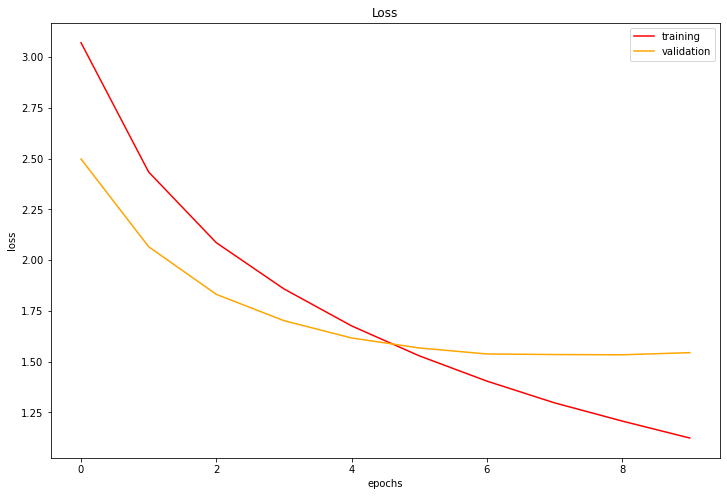

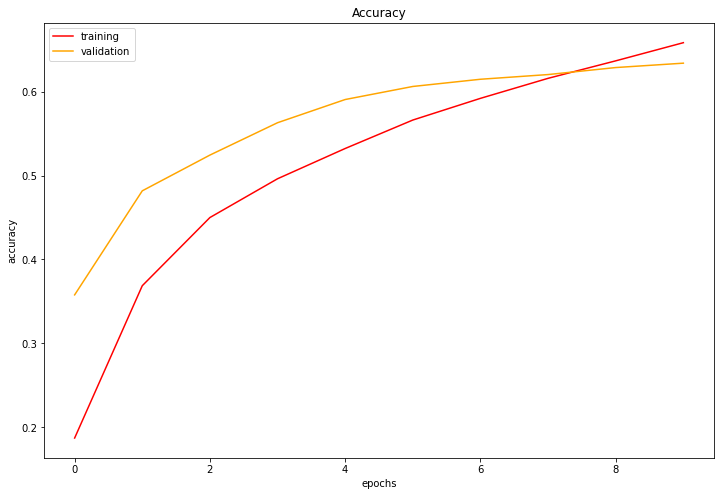

In [36]:
EvaluateModel(model, X_test, y_test, history)

In [45]:
p = model.predict_classes(X_test, verbose=0)
print(metrics.classification_report(np.argmax(y_test, axis=1), p))
print(metrics.confusion_matrix(np.argmax(y_test, axis=1), p))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       766
           1       0.56      0.45      0.50       902
           2       0.29      0.63      0.40      1182
           3       0.00      0.00      0.00       229
           4       0.54      0.53      0.54      1020
           5       0.29      0.47      0.36       679
           6       0.77      0.71      0.74       682
           7       0.00      0.00      0.00       200
           8       0.74      0.79      0.77      3204
           9       0.00      0.00      0.00       249
          10       0.91      0.04      0.07       280
          11       0.65      0.88      0.75      1242
          12       0.12      0.00      0.01       279
          13       0.30      0.16      0.21       522
          14       0.21      0.06      0.10      1332
          15       0.77      0.81      0.79       814
          16       0.34      0.09      0.14       688
          17       0.00    